### 학생 성적 데이터 
1. 자료 분석 및 시각화(EDA)
2. 결측치를 식별하고 결측치를 예측
3. 범주형 변수 인코딩
4. 데이터 분할
5. svm, xgboost, randomforest 3개의 알고리즘 사용하여 어떠한 모델이 더 좋은가 판단

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("./data/student_data.csv")
df.head()

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,GP,F,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,GP,F,no,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,GP,F,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,GP,F,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,GP,F,yes,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10


### EDA

In [3]:
## 데이터의 타입 확인 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   paid        395 non-null    object 
 3   activities  395 non-null    object 
 4   famrel      394 non-null    float64
 5   freetime    393 non-null    float64
 6   goout       392 non-null    float64
 7   Dalc        391 non-null    float64
 8   Walc        393 non-null    float64
 9   health      391 non-null    float64
 10  absences    392 non-null    float64
 11  grade       395 non-null    int64  
 12  G1          395 non-null    int64  
 13  G2          395 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 43.3+ KB


In [4]:
df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        1
freetime      2
goout         3
Dalc          4
Walc          2
health        4
absences      3
grade         0
G1            0
G2            0
dtype: int64

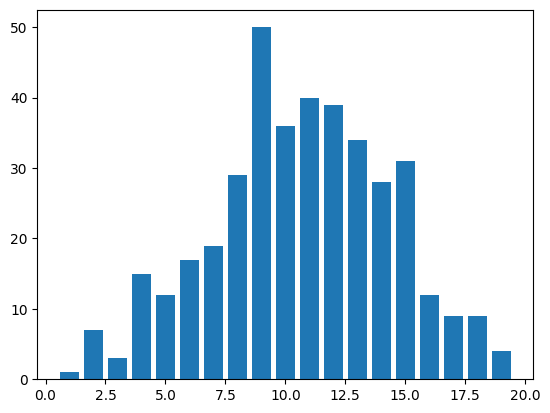

학생 성적의 평균 :  10.660759493670886


In [5]:
## 종속 변수 분포 확인
import matplotlib.pyplot as plt

plt.bar(df['grade'].value_counts().index, df['grade'].value_counts().values)
plt.show()
print('학생 성적의 평균 : ', df['grade'].mean())

In [6]:
import scipy.stats as stats

stats.shapiro(df['grade'])

ShapiroResult(statistic=np.float64(0.987124064270881), pvalue=np.float64(0.0014292315891789487))

종속 변수 성적에 대한 분포를 확인한 결과 평균 근처에서 관측치가 많은 정규 분포의 형태
Shapiro test 결과도 p-value가 0.05 이하로 정규성을 띄고 있다

해당 종속 변수의 값이 정규성을 띄고 다양한 값이 있으므로 회귀 분석

### 독립 변수 EDA

In [7]:
import seaborn as sns

df_cor = df.corr(method='pearson')

sns.heatmap(df_cor, 
            xticklabels = df_cor.columns, 
            yticklabels = df_cor.columns, 
            cmap = 'RdBu_r', 
            annot = True, 
            linewidth = 3)

ValueError: could not convert string to float: 'GP'

<BarContainer object of 2 artists>

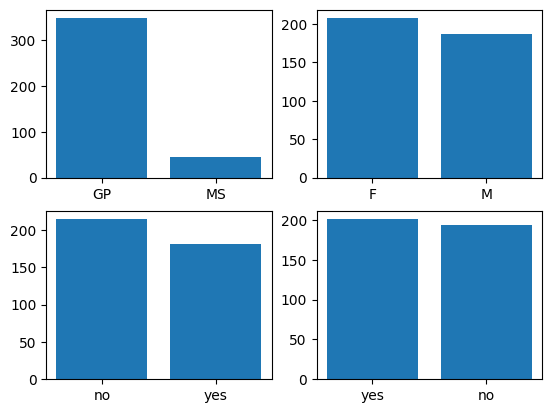

In [8]:
## 범주형 변수 시각화
fig, axs = plt.subplots(2, 2)

axs[0][0].bar(df['school'].value_counts().index, df['school'].value_counts().values)

axs[0][1].bar(df['sex'].value_counts().index, df['sex'].value_counts().values)

axs[1][0].bar(df['paid'].value_counts().index, df['paid'].value_counts().values)

axs[1][1].bar(df['activities'].value_counts().index, df['activities'].value_counts().values)

In [9]:
## 전체 데이터에서 결측치가 몇 %가 되는가?
df.isna().sum().sum()/(395*11)

np.float64(0.004372842347525892)

- 변수 해석 
    - 결측치 존재 여부
        - 전체 데이터에서 famrel, goout, Dalc, Walc, absences 변수에서 결측치가 존재
        - 결측치의 개수가 전체에 1%로 되지 않는다. 
        - 결측치가 존재하는 변수들은 float 형태로 평균값으로 대체, KNN을 사용
    - 데이터 타입
        - 종속 변수는 int
        - 독립 변수는 object와 float 
        - object의 형태는 인코딩하여 변환
    - 종속 변수의 분포
        - 종속 변수의 분포 정규 분포
    - 종속 변수와 독립 변수의 상관관계
        - 종속변수 grade와의 상관 관계수를 확인
        - 수치형 변수에서는 상관성 크게 존재하지 않는다. 
        - 새로운 파생변수의 필요성이 보인다. 
    - 독립 변수의 상관 관계
        - 다중공선성을 걱정할 정도의 상관성을 보이지는 않는다. 
        - G1과 G2는 관계가 높기 때문에 주의
    - school 변수의 경우 비대칭임으로 주의

### 결측치 식별, 결측치 예측

In [10]:
df[df.isna().any(axis=1)]

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
9,GP,M,yes,yes,5.0,5.0,NaN,1.0,1.0,5.0,0.0,15,14,15
14,GP,M,no,no,NaN,5.0,2.0,1.0,1.0,3.0,0.0,15,14,16
15,GP,F,no,no,4.0,4.0,4.0,1.0,2.0,2.0,NaN,14,14,14
25,GP,F,yes,no,1.0,2.0,2.0,1.0,NaN,5.0,14.0,8,6,9
39,GP,F,yes,yes,4.0,3.0,1.0,1.0,1.0,NaN,8.0,13,14,13
40,GP,F,no,yes,3.0,3.0,NaN,1.0,2.0,3.0,25.0,9,7,10
49,GP,F,no,yes,4.0,4.0,4.0,1.0,1.0,NaN,2.0,7,7,7
61,GP,F,no,yes,5.0,5.0,5.0,NaN,5.0,5.0,6.0,10,10,8
71,GP,M,no,no,3.0,3.0,3.0,NaN,1.0,3.0,0.0,10,10,10
82,GP,F,yes,no,4.0,4.0,4.0,1.0,1.0,5.0,NaN,6,7,6


- KNN을 이용할때는 거리 계산이 가능한 수치형 변수에만 사용이 가능
- 해당 데이터에서는 한 행이 전부 결측치인 경우가 존재하지 않기 때문에 삭제X, 대체O
- 수치형 데이터만 결측치가 존재 KNN기법을 사용하여 대체

In [11]:
from sklearn.impute import KNNImputer

## 결측치가 존재하는 컬럼만 추출
KNN_data = df.drop(columns=['school', 'sex', 'paid', 'activities'])

## 모델링 
imputer = KNNImputer()
df_filled = imputer.fit_transform(KNN_data)
df_filled = pd.DataFrame(df_filled, columns=KNN_data.columns)
df[KNN_data.columns] = df_filled

## 결측치 확인
df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
grade         0
G1            0
G2            0
dtype: int64

### 범주형 변수 인코딩 
- school, sex, paid, activities 컬럼들은 이산형 변수임으로 boolean 타입으로 변경하여 머신러닝에서 변수 사용 가능하도록 변환
- 나머지 변수들은 수치 or 순위형 변수로 판단 인코딩 X

In [12]:
df = pd.get_dummies(data = df, columns = ['school', 'sex', 'paid', 'activities'], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   famrel          395 non-null    float64
 1   freetime        395 non-null    float64
 2   goout           395 non-null    float64
 3   Dalc            395 non-null    float64
 4   Walc            395 non-null    float64
 5   health          395 non-null    float64
 6   absences        395 non-null    float64
 7   grade           395 non-null    float64
 8   G1              395 non-null    float64
 9   G2              395 non-null    float64
 10  school_MS       395 non-null    bool   
 11  sex_M           395 non-null    bool   
 12  paid_yes        395 non-null    bool   
 13  activities_yes  395 non-null    bool   
dtypes: bool(4), float64(10)
memory usage: 32.5 KB


### 데이터의 분할
- 해당 데이터는 종속 변수가 연속형이므로 회귀분석을 사용
- 랜덤 샘플링을 통한 분할 7:3 비율로 분할

In [13]:
x = df.drop('grade', axis=1)
y = df['grade']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=2023)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(276, 13) (119, 13) (276,) (119,)


### svm, xgboost, rendomforest 알고리즘 실행

In [14]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

### xgboost 모듈이 존재하지 않는다면 
!pip install xgboost

In [15]:
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [16]:
## 매개변수 찾기
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = [
    {'C' : [0.1, 1, 10, 100], 
    'gamma' : [0.001, 0.01, 0.1, 1, 10]}
]

grid_svm = GridSearchCV(SVR(), param_grid=param_grid, cv = 5)
grid_svm.fit(x_train_scaled, y_train)

result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,C,gamma,mean_test_score
15,100.0,0.001,0.960803
11,10.0,0.010,0.958508
16,100.0,0.010,0.951196
10,10.0,0.001,0.942653
6,1.0,0.010,0.927551
12,10.0,0.100,0.880696
17,100.0,0.100,0.878937
7,1.0,0.100,0.809544
5,1.0,0.001,0.296297
2,0.1,0.100,0.287447


In [18]:
svr = SVR(C=100, gamma=0.001)
svr.fit(x_train_scaled, y_train)

print('R2 :', svr.score(x_test_scaled, y_test))
print('RMSE :', np.sqrt(mean_squared_error(y_test, svr.predict(x_test_scaled))))

R2 : 0.9547061514122562
RMSE : 0.8546763465791851


In [19]:
## 랜덤포레스트
rf_grid = [
    {'max_depth' : [2, 4, 6, 8, 10], 
    'min_samples_split' : [2,4,6,8,10]}
]

rf = GridSearchCV(RandomForestRegressor(n_estimators=100), param_grid=rf_grid, cv = 5)
rf.fit(x_train, y_train)

print(rf.best_params_)
print('R2 :', rf.score(x_test, y_test))
print('RMSE :', np.sqrt(mean_squared_error(y_test, rf.predict(x_test))))

{'max_depth': 10, 'min_samples_split': 6}
R2 : 0.9668482501527068
RMSE : 0.7311985159265287


In [20]:
xgb_grid = [
    {
        'max_depth' : [2,4,6,8,10]
    }
]

xgb = GridSearchCV(XGBRegressor(n_estimators=1000), param_grid=xgb_grid, cv = 5)
xgb.fit(x_train, y_train)

print('R2 :', xgb.score(x_test, y_test))
print('RMSE :', np.sqrt(mean_squared_error(y_test, xgb.predict(x_test))))


R2 : 0.9603623043797329
RMSE : 0.799532776394679


### 해석 
- 가장 적절한 알고리즘 선택 
    - 랜덤포레스트 모델이 가장 정확도가 높고 RMSE값이 낮으므로 예측 분석력이 좋다